In [24]:
import sys, os; sys.path.insert(0, os.path.abspath('..'))
os.chdir("..")

import os
import io
import coiled
import requests
import numpy as np
import pandas as pd
import lightkurve as lk
from pipeline import unpopular
from pipeline.plotting import make_plot
from pipeline.lightcurves import make_lightcurves, load_lc, load_lc_pandas, _download_cutouts, _get_sector

In [25]:
targets = pd.read_csv("./misc/targets.csv")
targets = [tuple(t) for t in list(targets.itertuples())]

In [ ]:
def process_target(target):
    _, tic, ra, dec = target
    cutouts = _download_cutouts(ra=ra, dec=dec)

    for cutout in cutouts:
        s = unpopular.Source(cutout, remove_bad=True)

        s.set_aperture(rowlims=[25, 25], collims=[25, 25])
        s.add_cpm_model(exclusion_size=5, n=64, predictor_method="similar_brightness")

        s.set_regs([0.1])
        s.holdout_fit_predict(k=100)

        apt_detrended_flux = s.get_aperture_lc(data_type="cpm_subtracted_flux")

        buffer = io.BytesIO()
        np.savez_compressed(buffer, time=s.time, flux=apt_detrended_flux)
        buffer.seek(0)

        sector = int(cutout.split("/")[-1].split("-")[1].strip("s"))
        requests.post(
            "http://gideon.sytes.net/upload.php",
            files={"file": (f"{tic}_{sector}.npz", buffer, "application/octet-stream")},
        )

In [11]:
process_target(targets[1])

Removing 1497 bad data points (out of 3534) using the TESS provided QUALITY array
Summing over 1 x 1 pixel lightcurves. Weighting=None
Removing 1095 bad data points (out of 10730) using the TESS provided QUALITY array
Summing over 1 x 1 pixel lightcurves. Weighting=None


In [26]:
lc = np.load("./notebooks/33398702_42.npz")
lc = lk.LightCurve(time=lc["time"], flux=lc["flux"])

lc.meta["TIC"] = "TIC 33398702"
lc.meta["SECTOR"] = 42

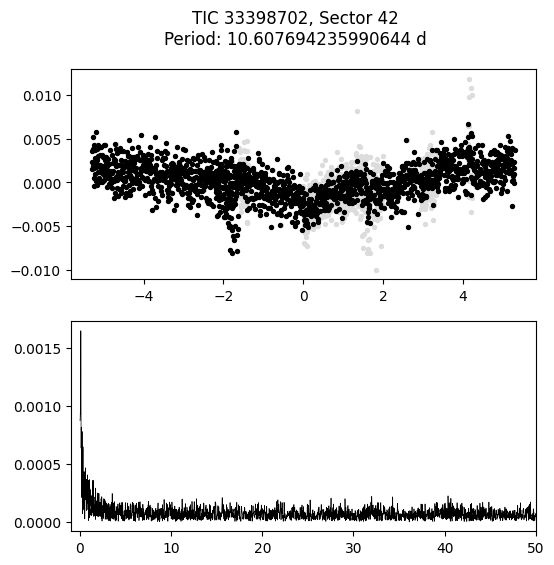

In [28]:
make_plot(lc);

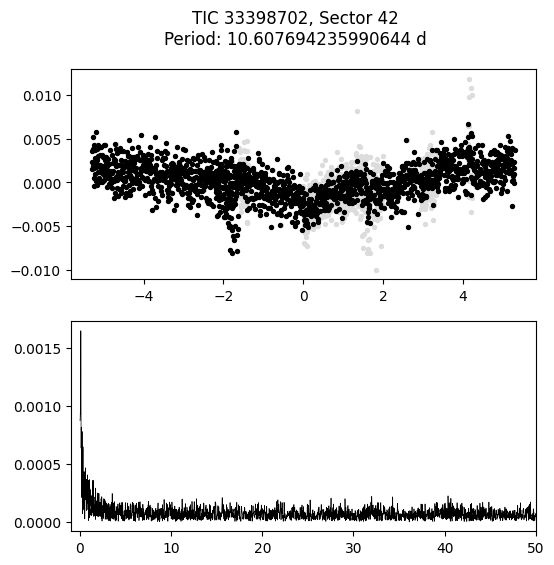

In [29]:
make_plot(load_lc("TIC 33398702", 42));